# Steam Data
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the weather.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
STEAM_FILE='steam.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [4]:
stm_df = read_zip_to_panda(ZIP_PATH,STEAM_FILE)
stm_df = fix_date_type(stm_df)
print(stm_df.info()) # only 371 columns (buildings) in this data. Includes Peacock but not Gator. 



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 370 entries, Peacock_lodging_Terrie to Cockatoo_public_Shad
dtypes: float64(370)
memory usage: 49.7 MB
None


In [5]:
cols=stm_df.columns
all_sites=[s.split('_')[0] for s in cols]  # Site is first part of building name like Hog_parking_Linda
uniq_sites = [x for x in set(all_sites)]
site_counts = [[x,all_sites.count(x)] for x in set(all_sites)]
print("Note we only have a few sites!")
print("Buildings per site:\n",site_counts)

Note we only have a few sites!
Buildings per site:
 [['Peacock', 34], ['Hog', 97], ['Moose', 12], ['Bull', 90], ['Cockatoo', 92], ['Eagle', 45]]


## Plot usage per site
Look for completeness and variability.

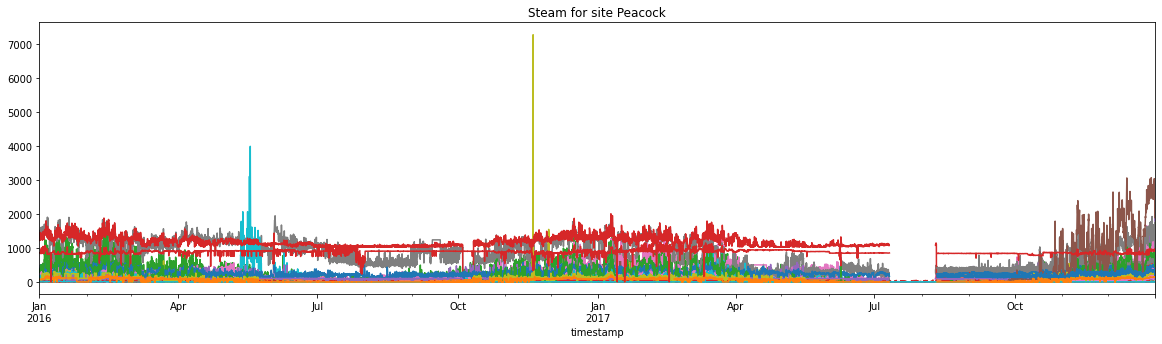

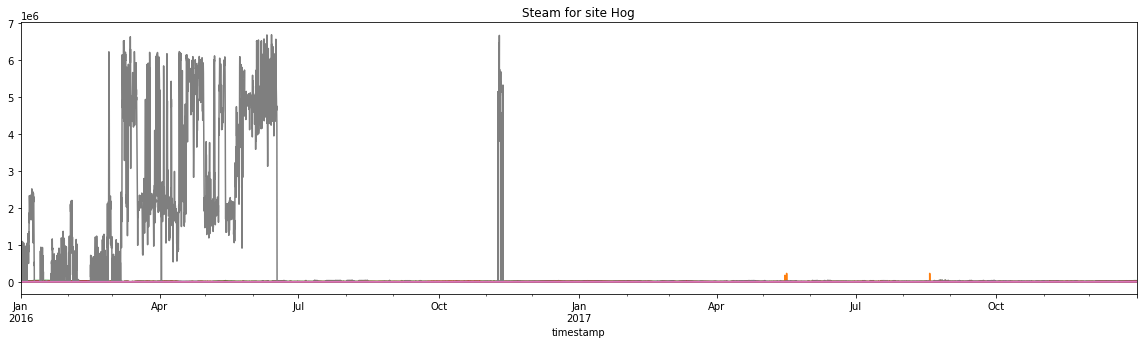

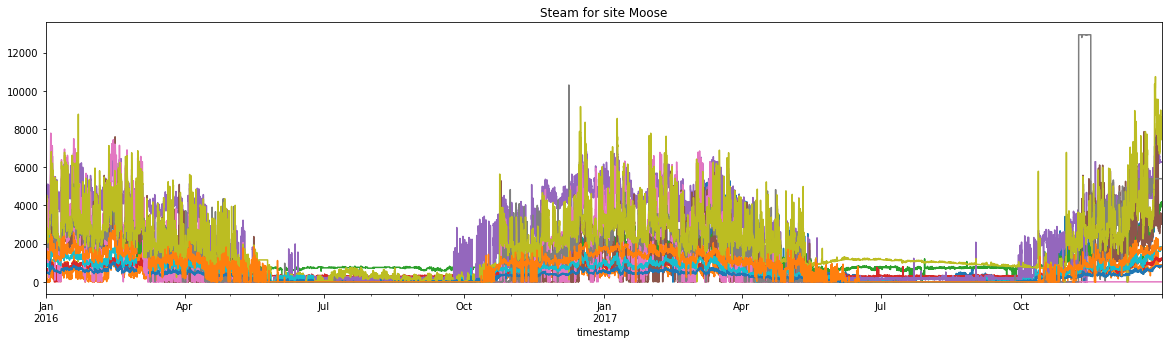

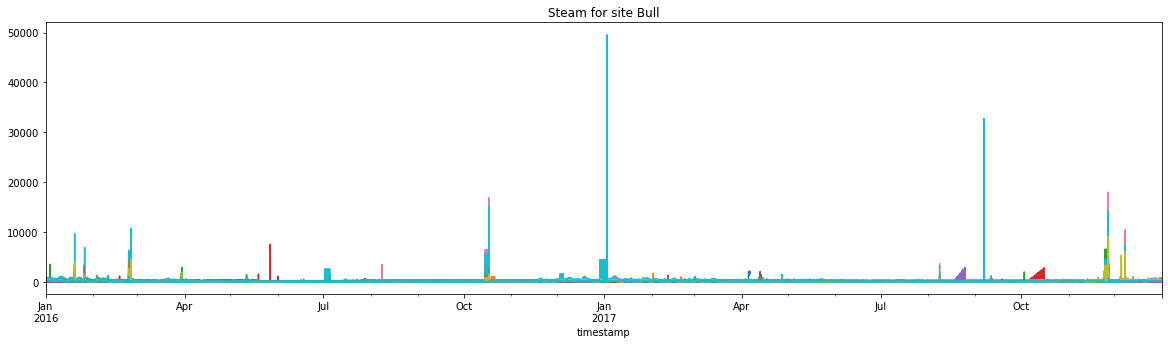

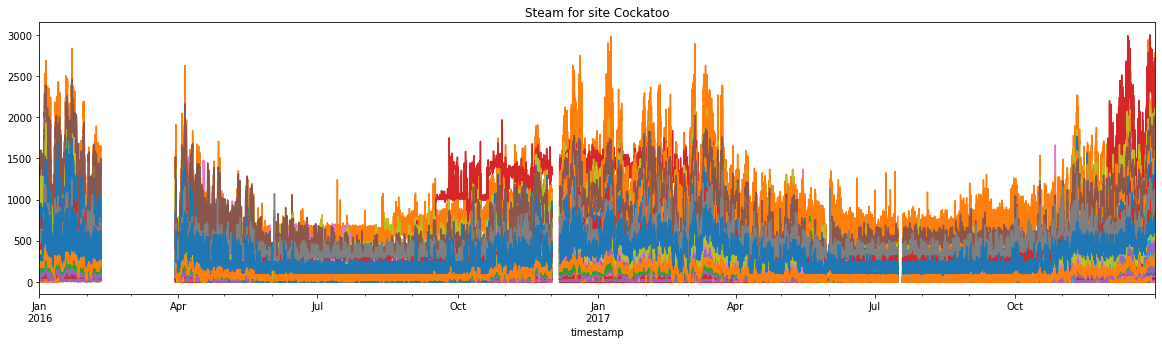

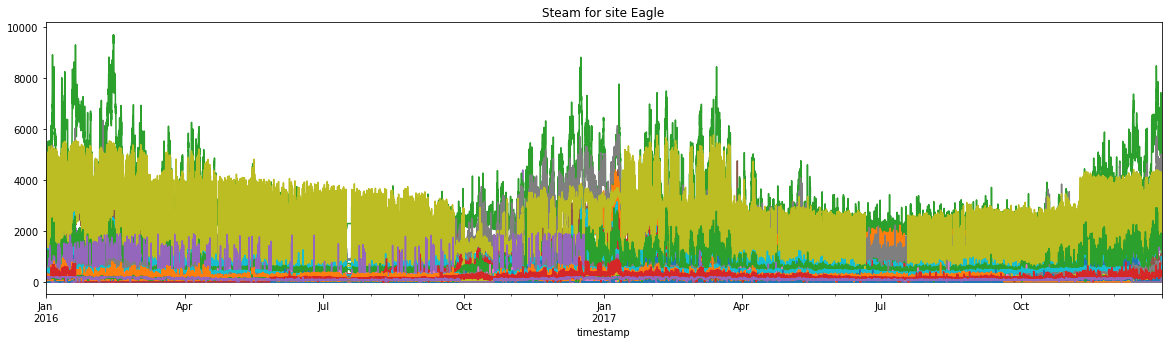

In [6]:
# Plot temperature time series for one column (building). 
cols=stm_df.columns
uniq_sites = [x for x in set(all_sites)]
for site in uniq_sites:
    for bldg in cols:
        if bldg.startswith(site):
            temp_df = stm_df[bldg]
            temp_df.plot(figsize=(20,5))
    plt.title("Steam for site "+site)
    plt.show()

## Drill down on Eagle
This site seems fairly complete.

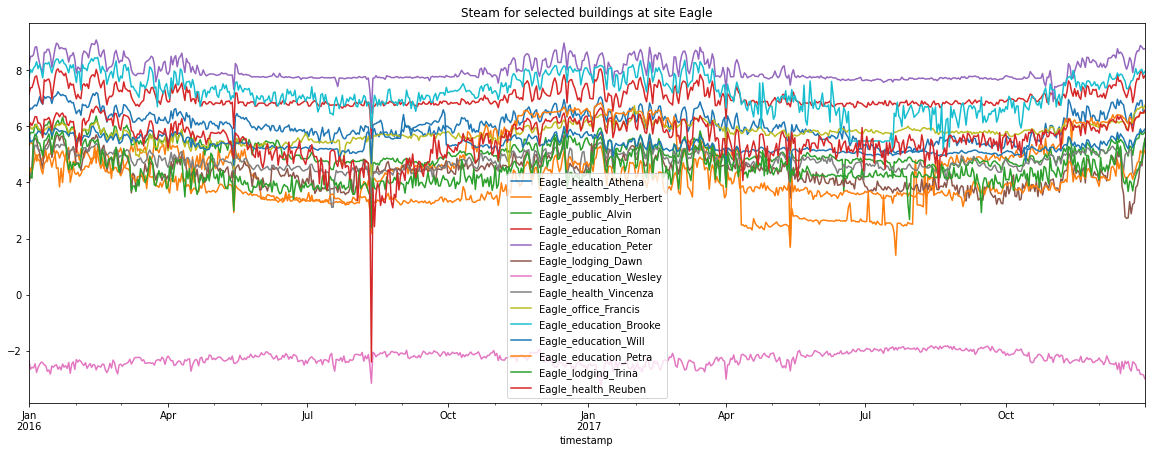

Suitable buildings from site Eagle :
 ['Eagle_health_Athena', 'Eagle_assembly_Herbert', 'Eagle_public_Alvin', 'Eagle_education_Roman', 'Eagle_education_Peter', 'Eagle_lodging_Dawn', 'Eagle_education_Wesley', 'Eagle_health_Vincenza', 'Eagle_office_Francis', 'Eagle_education_Brooke', 'Eagle_education_Will', 'Eagle_education_Petra', 'Eagle_lodging_Trina', 'Eagle_health_Reuben']


In [43]:
# Plot temperature time series for one column (building). 
cols=stm_df.columns
uniq_sites = [x for x in set(all_sites)]
site = 'Eagle'
suitable_bldgs=[]
for bldg in cols:
    if bldg.startswith(site):
        temp_df = stm_df[bldg]
        smooth = temp_df.resample("1D").mean()  
        count_nan=np.isnan(smooth).sum()
        count_zero=smooth.isin([0]).sum()
        if count_nan<=0 and count_zero<=0:
            suitable_bldgs.append(bldg)
            logs = np.log(smooth)
            logs.plot(figsize=(20,7))
plt.title("Steam for selected buildings at site "+site)
plt.legend()
plt.show()
print("Suitable buildings from site",site,":\n",suitable_bldgs)
